# 3.2 비트코인 시세 예측하기

비트코인 시세처럼 연속적인 시간에 따라 다르게 측정되는 데이터를 **시계열 데이터**라 하며, 이를 분석하는 것을 '시계열 데이터 분석'이라고 한다.

## Step 1 탐색: 시간 정보가 포함된 데이터 살펴보기

비트코인 데이터셋을 살펴보면, 총 365개의 행으로 이루어진 것을 알 수 있다. 또한 데이터는 결측값 없이 날짜와 가격에 대한 2개의 피처로 구성되어 있고, 이러한 데이터셋을 **시계열 데이터셋**이라고 한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 파일 불러오기
file_path = 'data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price']) # 열 이름 설정

# 기본 정보 출력
print(bitcoin_df.shape)
print(bitcoin_df.info())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


아래의 코드는 시계열 정보를 데이터 프레임의 index로 설정하여 가격의 추이를 시각화한 것이다.

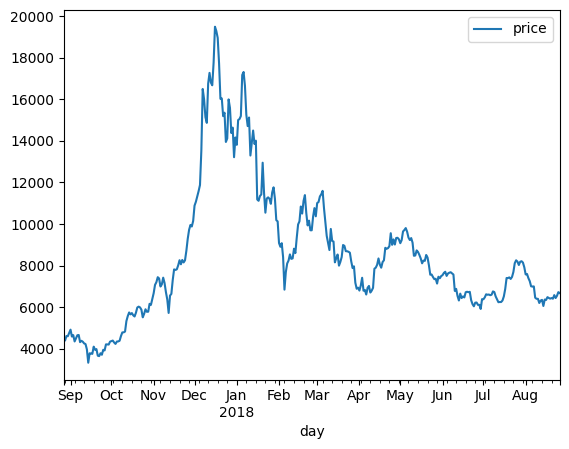

In [2]:
# to_datetime으로 day 피처를 시계열 피처로 변환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터 프레임의 index로 설정
bitcoin_df.index = bitcoin_df['day'] # x축 설정
bitcoin_df.set_index('day', inplace=True)

# 일자별 비트코인 시세를 시각화
bitcoin_df.plot()
plt.show()

## Step 2 예측: 파이썬 라이브러리를 활용해 시세 예측하기

첫 번째로 사용할 시계열 예측 분석 방법은 **ARIMA** 분석 방법이다. ARIMA는 크게 두 가지 개념을 포함하고 있는데, 첫 번째는 AR모델로 자기 자신의 과거를 정보로 사용하는 개념이다. 두 번째 개념은 MA 모델로 이전 항에서의 오차를 이용해 현재 항의 상태를 추론하는 방법이다. 이 둘을 합친 것을 **ARMA** 모델이라고 하며, 조금 더 나아간 **ARIMA** 모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법이다.

파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있다. 다음 코드는 ARIMA 분석의 실행 과정이다. ARIMA 클래스에 order=(2,1,2)라고 입력된 파라미터는 AR이 몇 번째 과거까지를 바라보는지에 대한 파라미터(2), 차분에 대한 파라미터(1), MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터(2)를 의미한다.

차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미하며, 시계열 데이터의 불규칙성을 보정해주는 역할을 한다. 즉, ARIMA 모델의 경향성을 의미한다.

**책이 좀 옛날 버전이라 24년 기준으로 모듈, 함수 사용법이 많이 달라져서 Chat-GPT를 이용하여 몇 가지를 추가하였지만, 정확성은 잘 모르겠다..**

auto_arima()를 이용하여 자동 파라미터를 설정하였더니 order=(0,1,0)일 때 최적의 파라미터라고 한다. 하지만 order=(2,1,2)로 학습하였다.

In [3]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from pmdarima import auto_arima
import pandas as pd

# ARIMA 모델을 위한 자동 파라미터 선택
auto_model = auto_arima(bitcoin_df['price'], seasonal=False, trace=True) # seasonal: 계절성을 고려할지 여부를 설정, trace: 모델 선택 과정을 자세히 출력할지 여부를 설정

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습
#model = ARIMA(bitcoin_df.price.values, order=(auto_model.order))
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5586.967, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5583.718, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5584.063, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5583.897, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5581.775, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5583.265, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.490
Date:                Thu, 11 Jul 2024   AIC                           5584.980
Time:                        20:16:38   BIC                           5604.466
Sample:                             0   HQIC                          5592.725
          

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


아래의 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프이다. 만약 이 그래프의 폭이 일정하다면 좋은 예측 모델을 학습시킨 것이라고 볼 수 있다. 하지만 실행 결과를 보면, 오차 변동이 매우 불안정한 것으로 보인다.

<Axes: >

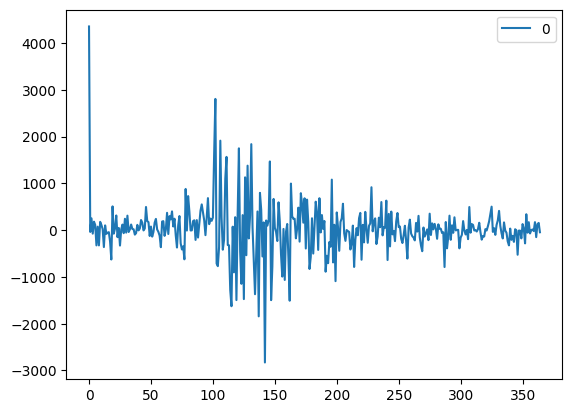

In [4]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

다음으로 ARIMA 모델을 평가해보자. 모델을 평가하기 위해 테스트 전용 데이터가 필요한데, 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용한다. 뷸규칙적 시계열 예측의 경우 먼 미래를 예측하는 것은 큰 의미가 없기 때문이다.

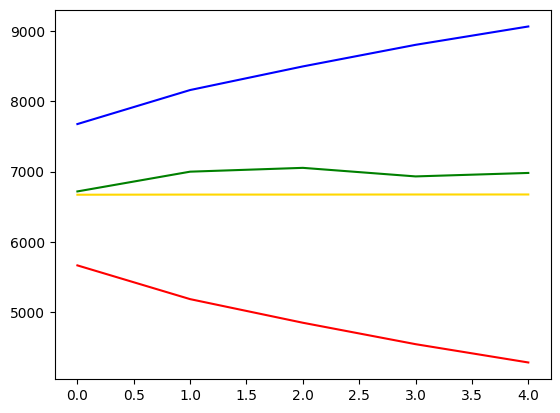

In [6]:
forecast_data = model_fit.get_forecast(steps=5)
# 테스트 데이터셋을 불러옴
test_file_path = './data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 예측값과 신뢰 구간을 포함한 프레임을 얻는다
forecast_df = forecast_data.summary_frame()
pred_y = forecast_df['mean'].tolist() # 마지막 5일의 예측 데이터
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터
pred_y_lower = forecast_df['mean_ci_lower'].tolist()
pred_y_upper = forecast_df['mean_ci_upper'].tolist()

plt.plot(pred_y, color="gold")
plt.plot(pred_y_lower, color="red")
plt.plot(pred_y_upper, color="blue")
plt.plot(test_y, color="green")

아래는 실제 그래프와 예측 그래프를 나타낸 것이다. 그래프의 상승 경향을 보면 좋지 않은 예측을 한 것으로 보인다. 하지만 '5일 동안 상승할 것이다'라는 아주 큰 트렌드 정도는 예측 가능하다.(아주 미세하지만)

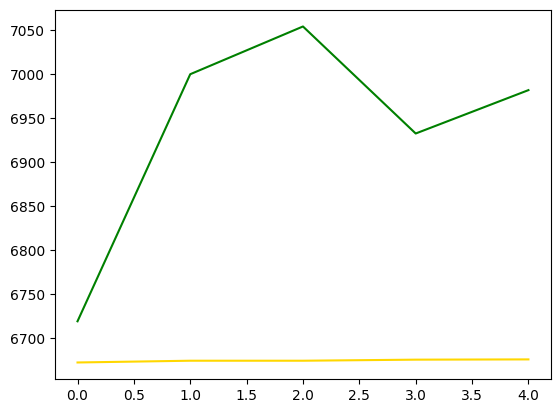

In [7]:
plt.plot(pred_y, color="gold")
plt.plot(test_y, color="green")

다음으로 RMSE를 계산해보자

In [29]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

287.09158444708197


이번에는 ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 Facebook Prophet을 사용해보자. Prophet은 Additive 모델이라는 모델링 방법에 기반한 시계열 예측 모델로서 시계열 데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있다.

prophet 라이브러리를 사용하기 위해서는 데이터 프레임의 피처를 'ds'와 'y'로 변경해야 한다.

모델 생성에 포함되는 파라미터 의미는 다음과 같다.
* seasonality_mode: 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미
* changepoint_prior_scale: 트렌드가 변경되는 문맥을 반영하는 파라미터. 수치가 높을수록 모델은 과적합에 가까워짐

In [31]:
from prophet import Prophet # fbprophet에서 prophet로 바뀜

# 데이터 프레임의 피처를 'ds'와 'y'로 변경
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing


make_future_dataframe(periods=5, freq='d'), prophet.predict(future_data)를 실행하면 학습 데이터셋 기반의 5일 단위 예측 데이터를 얻을 수 있다.

In [32]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6978.697763,6309.031225,7621.916964
366,2018-08-28,7082.561527,6311.949601,7756.841216
367,2018-08-29,7111.709229,6462.853522,7798.941697
368,2018-08-30,7195.310702,6462.828474,7883.733354
369,2018-08-31,7278.045865,6526.382861,8071.221981


아래는 prophet 모델의 학습 결과를 시각화한 결과이다. 그래프의 검은 점은 실제 가격을 나태낸 것이고, 파란 선은 예측 가격을 나타낸 것이다. 즉, 학습 데이터셋에 대해서는 정확한 예측을 하고 있다. 하지만 학습 데이터를 잘 예측하는 것은 큰 의미가 없다.

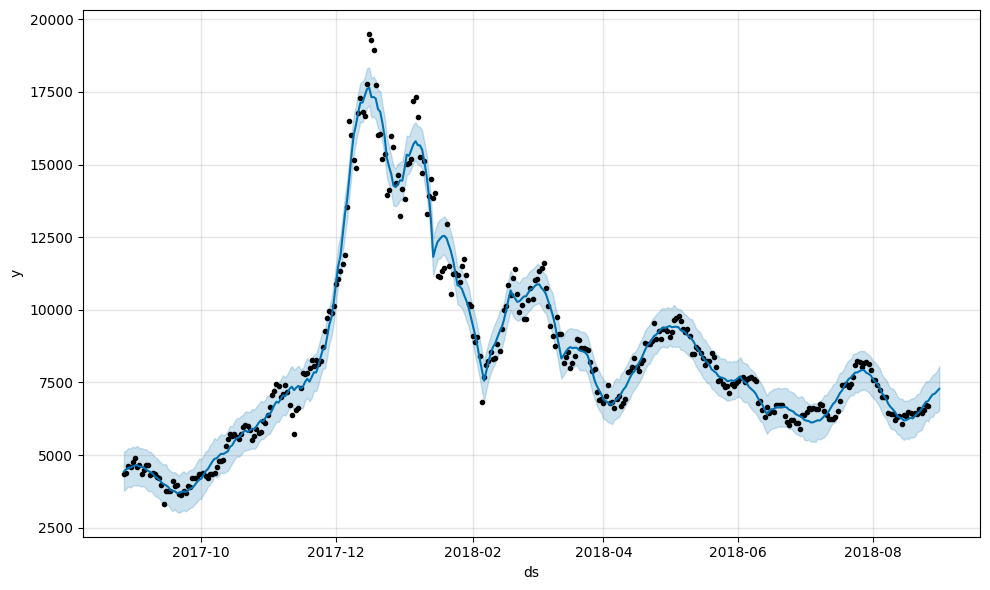

In [34]:
fig = prophet.plot(forecast_data)

다음 그래프는 prophet에서 제공하는 트렌드 정보 시각화 그래프이다. 앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 이 시각화가 가능하다. 이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지 살펴볼 수 있다.

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

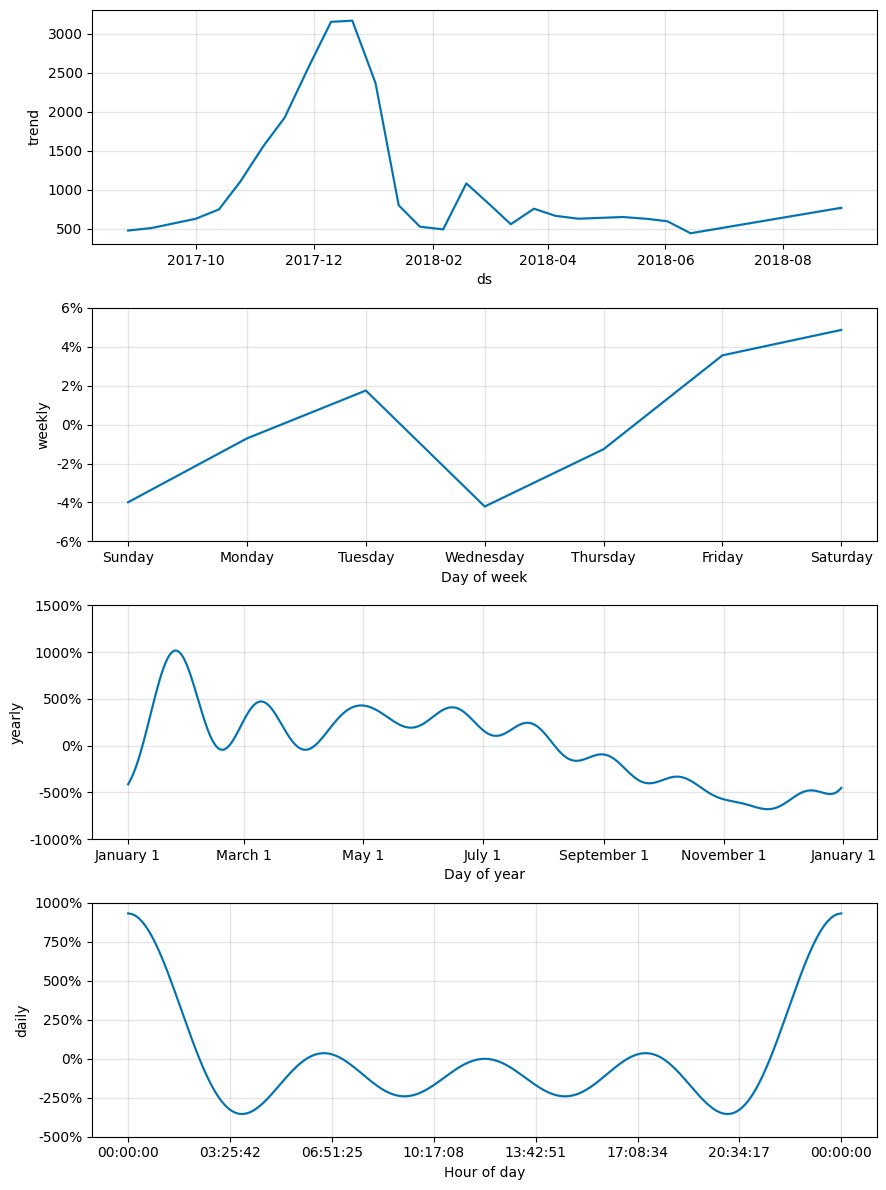

In [35]:
fig2 = prophet.plot_components(forecast_data)

이제 테스트 데이터셋을 평가해보자. ARIMA 모델보다는 prophet 모델이 실제 price 값에 더 근접한 예측을 하는 것처럼 보인다.

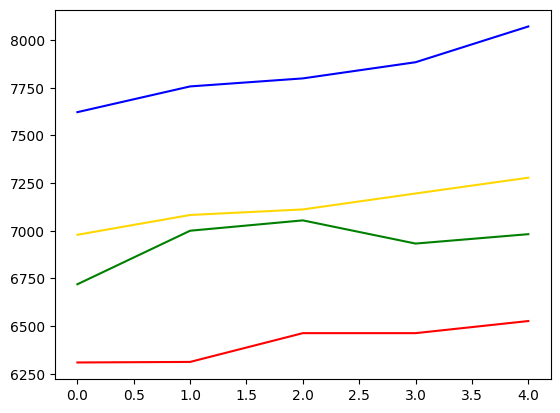

In [36]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 마지막 5일의 예측 데이터 (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data.yhat.values[-5:]
# 실제 5일 가격 데이터
test_y = bitcoin_test_df.y.values
# 마지막 5일 예측 데이터의 최소값
pred_y_lower = forecast_data.yhat_lower.values[-5:]
# 마지막 5일 예측 데이터의 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold")
plt.plot(pred_y_lower, color="red")
plt.plot(pred_y_upper, color="blue")
plt.plot(test_y, color="green")

아래 그래프를 보면 '5일 동안 얼마만큼 상승할 것이다'라는 트렌드를 꽤나 정확하게 예측한 것으로 보인다.

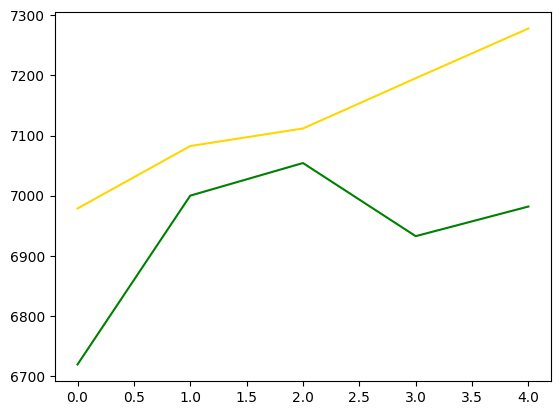

In [37]:
plt.plot(pred_y, color="gold")
plt.plot(test_y, color="green")

In [39]:
pred_y

array([6978.6977628 , 7082.56152702, 7111.70922927, 7195.31070195,
       7278.04586499])

RMSE 역시 ARIMA모델보다 감소한 것을 볼 수 있다.

In [38]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

216.36645103460737


## Step3 활용: 더 나은 결과를 위한 방법

모델의 성능을 조금 더 향상시킬 수 있는 방법들이 있는데, 첫 번째로 **상한값 혹은 하한값을 지정해 주는 것**이다.

18:45:04 - cmdstanpy - INFO - Chain [1] start processing
18:45:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


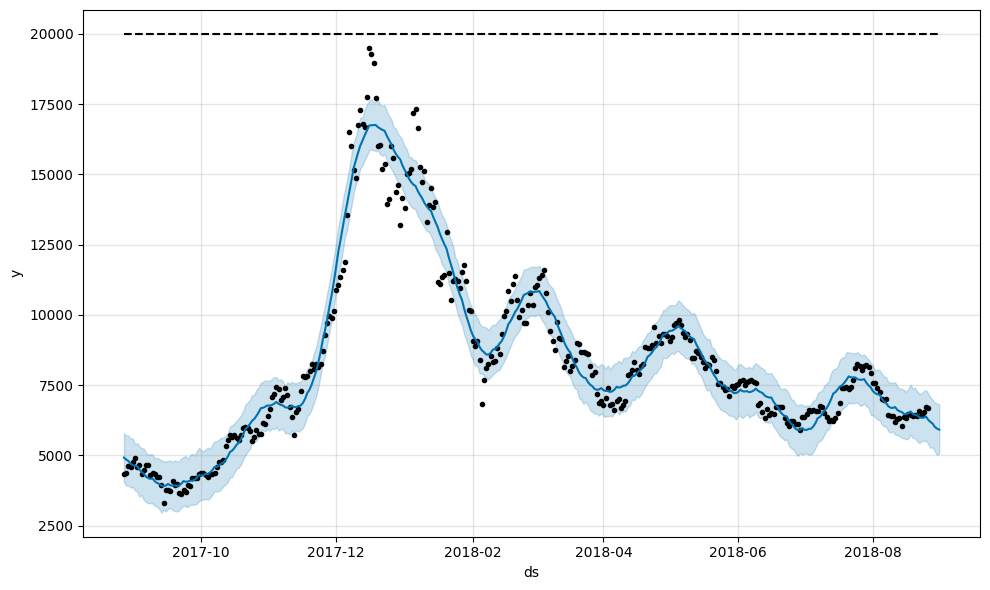

In [40]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
prophet = Prophet(seasonality_mode='multiplicative',
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

아래의 코드는 예측값과 실제값을 비교한 것이다.

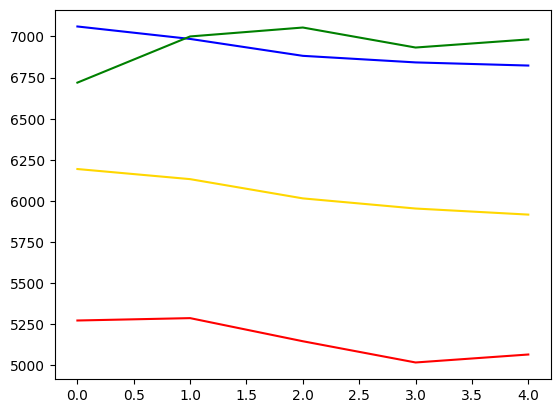

In [41]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예측한 마지막 5일의 가격 데이터를 가져옴
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예측한 하한가 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예측한 상한가 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

예측 모델이 형편없는 결과를 예측했다는 것을 알 수 있다. 모델이 예측한 상한가보다 실제 가격이 더 높기 때문이고, 또한 '5일 동안 상승/하락할 것이다'라는 큰 범위의 트렌드를 예측하는 것조차 실패했다. 즉, 상한가라는 개념이 큰 의미가 없는 비트코인 데이터의 경우 상한선을 설정한 것이 오히려 독이 된 것이다.

이제, 모델의 성능을 향상시키는 다른 방법 중 하나인 **이상치 제거 기법**을 살펴보자. 이상치란 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 말한다.

prophet 모델이 이상치를 제거한 데이터로 학습하려면 이상치에 해당하는 데이터를 None으로 설정해주면 된다. 아래의 코드에서는 18,000 이상을 이상치로 설정하였다. 그리고 나머지 부분은 이전과 동일하게 실행한다. 실행 후 그래프를 보면 이전과 큰 차이가 없어 보인다.

18:45:22 - cmdstanpy - INFO - Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


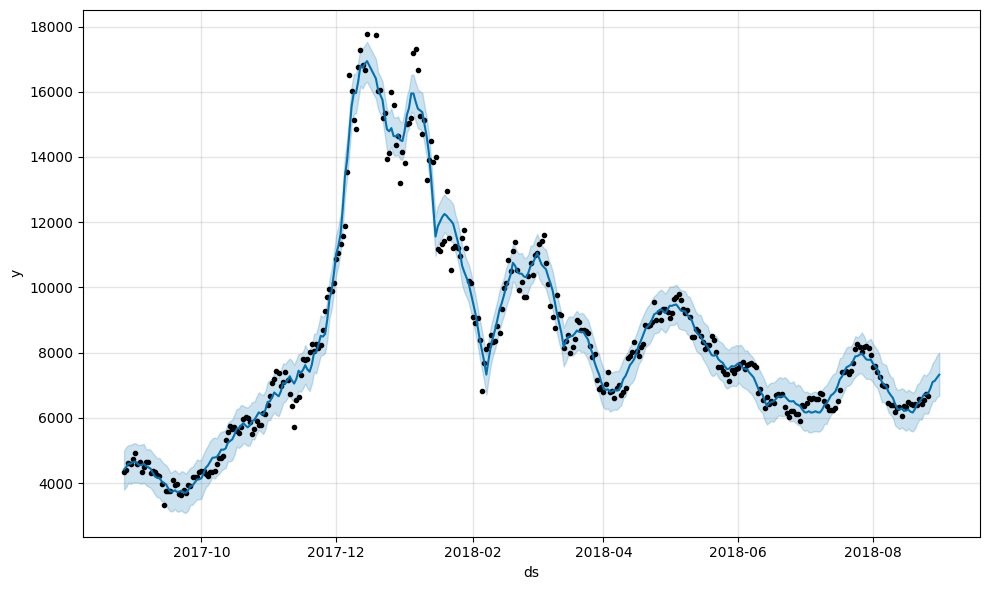

In [42]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

# prophet 모델을 학습
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일 단위의 미래를 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data)

마찬가지로 예측값과 실제값을 그래프로 나타내보자.

229.0955101437439


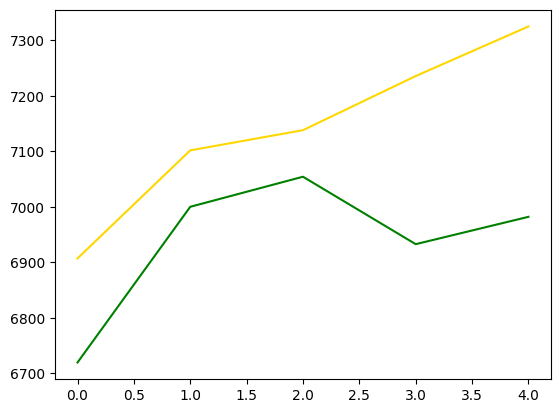

In [44]:
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values

plt.plot(pred_y, color="gold")
plt.plot(test_y, color="green")

# 테스트 데이터의 RMSE를 출력
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

In [45]:
pred_y

array([6906.98012122, 7101.82346243, 7138.23618277, 7235.83271257,
       7325.26224574])

살펴본 결과, 이상치를 제거하는 것이 정확도(RMSE)면에서는 살짝 떨어지지만, '트렌드'를 예측하는 측면에서는 이전 모델보다 더 낫다고 볼 수 있다.